# intro goes here...

https://qiskit.org/textbook/ch-algorithms/grover.html


In [1]:
#initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram

In [2]:
#        Vincent  Tess  Uma
# Vincent    -    x(0) x(1)
# Tess     x(2)    -   x(3)
# Uma      x(4)   x(5)  -


clause_list = [ [ 0 , 1 ] , # row 0
                [ 2 , 3 ] , # row 1
                [ 4 , 5 ] , # row 2
                [ 2 , 4 ] , # col 0
                [ 0 , 5 ] , # col 1
                [ 1 , 3 ] ] # col 2

In [3]:
def XOR ( qc , a , b , output ) :
    qc.cx ( a , output )
    qc.cx ( b , output )

In [4]:
def diffuser ( nqubits ) :
    qc = QuantumCircuit ( nqubits )
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range ( nqubits ) :
        qc.h ( qubit )
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range ( nqubits ) :
        qc.x ( qubit )
    # Do multi-controlled-Z gate
    qc.h ( nqubits - 1 )
    qc.mct ( list ( range ( nqubits - 1 ) ) , nqubits - 1 )  # multi-controlled-toffoli
    qc.h ( nqubits - 1 )
    # Apply transformation |11..1> -> |00..0>
    for qubit in range ( nqubits ) :
        qc.x ( qubit )
    # Apply transformation |00..0> -> |s>
    for qubit in range ( nqubits ) :
        qc.h ( qubit )
    # We will return the diffuser as a gate
    U_s = qc.to_gate ()
    U_s.name = 'U$_s$'
    return U_s

In [5]:
def sudoku_oracle ( qc , clause_list , clause_qubits ) :
    # Compute clauses
    i = 0
    for clause in clause_list :
        XOR ( qc , clause [ 0 ] , clause [ 1 ] , clause_qubits [ i ] )
        i += 1

    # Flip 'output' bit if all clauses are satisfied
    qc.mct ( clause_qubits , output_qubit )

    # Uncompute clauses to reset clause-checking bits to 0
    i = 0
    for clause in clause_list :
        XOR ( qc , clause [ 0 ] , clause [ 1 ] , clause_qubits [ i ] )
        i += 1

In [6]:
var_qubits = QuantumRegister ( 6 , name = 'v' )
clause_qubits = QuantumRegister ( 6 , name = 'c' )
output_qubit = QuantumRegister ( 1 , name = 'out' )
cbits = ClassicalRegister ( 6 , name='cbits' )
qc = QuantumCircuit ( var_qubits , clause_qubits , output_qubit , cbits )

# Initialize 'out0' in state |->
qc.initialize ( [ 1 , -1 ] / np.sqrt ( 2 ) , output_qubit )

# Initialize qubits in state |s>
qc.h ( var_qubits ) 
qc.barrier ()  # for visual separation

## First Iteration
# Apply our oracle
sudoku_oracle ( qc , clause_list , clause_qubits )
qc.barrier ()
# Apply our diffuser
qc.append ( diffuser ( 6 ) , [ 0 , 1 , 2 , 3 , 4 , 5 ] )

## Second Iteration
sudoku_oracle ( qc , clause_list , clause_qubits )
qc.barrier ()
# Apply our diffuser
qc.append ( diffuser ( 6 ) , [ 0 , 1 , 2 , 3 , 4 , 5 ] )

# Measure the variable qubits
qc.measure ( var_qubits , cbits )

qc.draw ( fold = -1 )

┌───┐               ░                                                                                                                               ░ ┌────────┐                                                                                                                              ░ ┌────────┐┌─┐               
    v_0: ─────────────┤ H ├───────────────░───■──────────────────────────────────■─────────────────────────────■──────────────────────────────────■───────────────────────░─┤0       ├──■──────────────────────────────────■─────────────────────────────■──────────────────────────────────■───────────────────────░─┤0       ├┤M├───────────────
                      ├───┤               ░   │                                  │                             │                                  │                       ░ │        │  │                                  │                             │                                  │                       ░ │        │└╥┘┌─┐            
    v_1: ─────────────┤ H ├───────────────░───┼──────────────■───────────────────┼──────────────■──────────────┼──────────────■───────────────────┼──────────────■────────░─┤1       ├──┼──────────────■───────────────────┼──────────────■──────────────┼──────────────■───────────────────┼──────────────■────────░─┤1       ├─╫─┤M├────────────
                      ├───┤               ░   │              │                   │              │              │              │                   │              │        ░ │        │  │              │                   │              │              │              │                   │              │        ░ │        │ ║ └╥┘┌─┐         
    v_2: ─────────────┤ H ├───────────────░───┼────■─────────┼──────────────■────┼──────────────┼──────────────┼────■─────────┼──────────────■────┼──────────────┼────────░─┤2       ├──┼────■─────────┼──────────────■────┼──────────────┼──────────────┼────■─────────┼──────────────■────┼──────────────┼────────░─┤2       ├─╫──╫─┤M├─────────
                      ├───┤               ░   │    │         │              │    │              │              │    │         │              │    │              │        ░ │  U$_s$ │  │    │         │              │    │              │              │    │         │              │    │              │        ░ │  U$_s$ │ ║  ║ └╥┘┌─┐      
    v_3: ─────────────┤ H ├───────────────░───┼────┼─────────┼────■─────────┼────┼──────────────┼────■─────────┼────┼─────────┼────■─────────┼────┼──────────────┼────■───░─┤3       ├──┼────┼─────────┼────■─────────┼────┼──────────────┼────■─────────┼────┼─────────┼────■─────────┼────┼──────────────┼────■───░─┤3       ├─╫──╫──╫─┤M├──────
                      ├───┤               ░   │    │         │    │         │    │              │    │         │    │         │    │         │    │              │    │   ░ │        │  │    │         │    │         │    │              │    │         │    │         │    │         │    │              │    │   ░ │        │ ║  ║  ║ └╥┘┌─┐   
    v_4: ─────────────┤ H ├───────────────░───┼────┼────■────┼────┼─────────┼────┼────■─────────┼────┼─────────┼────┼────■────┼────┼─────────┼────┼────■─────────┼────┼───░─┤4       ├──┼────┼────■────┼────┼─────────┼────┼────■─────────┼────┼─────────┼────┼────■────┼────┼─────────┼────┼────■─────────┼────┼───░─┤4       ├─╫──╫──╫──╫─┤M├───
                      ├───┤               ░   │    │    │    │    │         │    │    │         │    │         │    │    │    │    │         │    │    │         │    │   ░ │        │  │    │    │    │    │         │    │    │         │    │         │    │    │    │    │         │    │    │         │    │   ░ │        │ ║  ║  ║  ║ └╥┘┌─┐
    v_5: ─────────────┤ H ├───────────────░───┼────┼────┼────┼────┼────■────┼────┼────┼────■────┼────┼─────────┼────┼────┼────┼────┼────■────┼────┼────┼────■────┼────┼───░─┤5       ├──┼────┼────┼────┼────┼────■────┼────┼────┼────■────┼────┼─────────┼────┼────┼────┼────┼────■────┼────┼────┼───

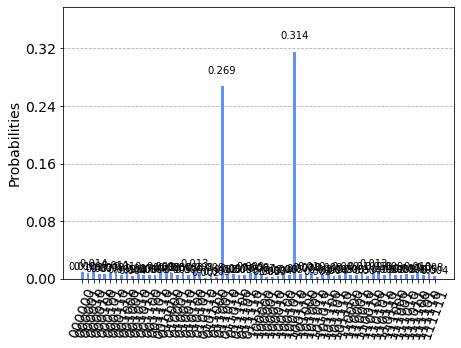

In [10]:
# Simulate and plot results
aer_sim = Aer.get_backend ( 'aer_simulator' )
transpiled_qc = transpile ( qc , aer_sim )
qobj = assemble ( transpiled_qc )
result = aer_sim.run ( qobj ).result ()
plot_histogram ( result.get_counts () )

In [27]:
    message =  { 0 : 'Vincent buys Tess a gift and writes her a poem' ,
                 1 : 'Vincent buys Uma a gift and writes her a poem' ,
                 2 : 'Tess buys Vincent a gift and writes him a poem' ,
                 3 : 'Tess buys Uma a gift and writes her a poem' ,
                 4 : 'Uma buys Vincent a gift and writes him a poem' ,
                 5 : 'Uma buys Tess a gift and writes her a poem' }

    for key, val in result.get_counts().items() :
        if val > 100 :
            print ( ' ' )
            i = 6
            for c in key :
                i -= 1
                if c == '1' :
                    print ( message [ i ] )

 
Uma buys Tess a gift and writes her a poem
Tess buys Vincent a gift and writes him a poem
Vincent buys Uma a gift and writes her a poem
 
Uma buys Vincent a gift and writes him a poem
Tess buys Uma a gift and writes her a poem
Vincent buys Tess a gift and writes her a poem
